<a href="https://colab.research.google.com/github/aztofighi/Image_Augmentation/blob/main/Albumentations_Fast_and_Flexible_Image_Augmentations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Albumentations: Fast and Flexible Image Augmentations

In this notebook, some of the examples in the [original Albumentations paper](https://www.mdpi.com/2078-2489/11/2/125) are implemented.


## Prepare the Google Colab environment

#### Download images

Download images that are used in the notebook and save to the `images` folder in the Colab environment.

In [1]:
!wget -q https://github.com/albumentations-team/albumentations_examples/archive/master.zip -O /tmp/albumentations_examples.zip
!unzip -o -qq /tmp/albumentations_examples.zip -d /tmp/albumentations_examples
!cp -r /tmp/albumentations_examples/albumentations_examples-master/notebooks/images .
!echo "Images are successfully downloaded"

Images are successfully downloaded


#### Install the latest version of Albumentations

Google Colab has an outdated version of Albumentations so we will install the latest stable version from PyPi.

In [2]:
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 3.5 MB/s eta 0:00:00
albumentations==1.3.1 is successfully installed


## Run the example

## Import libraries and define helper functions

### Import the required libraries

In [3]:
import os

import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.color import label2rgb

import albumentations as A
import random

### Define visualization functions

In [4]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White


def visualize_bbox(img, bbox, color=BOX_COLOR, thickness=2, **kwargs):
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    return img

def visualize_titles(img, bbox, title, color=BOX_COLOR, thickness=2, font_thickness = 2, font_scale=0.35, **kwargs):
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    ((text_width, text_height), _) = cv2.getTextSize(title, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness)
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(img, title, (x_min, y_min - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, font_scale, TEXT_COLOR,
                font_thickness, lineType=cv2.LINE_AA)
    return img


def augment_and_show(aug, image, mask=None, bboxes=[], categories=[], category_id_to_name=[], filename=None,
                     font_scale_orig=0.35, font_scale_aug=0.35, show_title=True, **kwargs):

    augmented = aug(image=image, mask=mask, bboxes=bboxes, category_id=categories)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_aug = cv2.cvtColor(augmented['image'], cv2.COLOR_BGR2RGB)

    for bbox in bboxes:
        visualize_bbox(image, bbox, **kwargs)

    for bbox in augmented['bboxes']:
        visualize_bbox(image_aug, bbox, **kwargs)

    if show_title:
        for bbox,cat_id in zip(bboxes, categories):
            visualize_titles(image, bbox, category_id_to_name[cat_id], font_scale=font_scale_orig, **kwargs)
        for bbox,cat_id in zip(augmented['bboxes'], augmented['category_id']):
            visualize_titles(image_aug, bbox, category_id_to_name[cat_id], font_scale=font_scale_aug, **kwargs)


    if mask is None:
        f, ax = plt.subplots(1, 2, figsize=(16, 8))

        ax[0].imshow(image)
        ax[0].set_title('Original image')

        ax[1].imshow(image_aug)
        ax[1].set_title('Augmented image')
    else:
        f, ax = plt.subplots(2, 2, figsize=(16, 16))

        if len(mask.shape) != 3:
            mask = label2rgb(mask, bg_label=0)
            mask_aug = label2rgb(augmented['mask'], bg_label=0)
        else:
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
            mask_aug = cv2.cvtColor(augmented['mask'], cv2.COLOR_BGR2RGB)

        ax[0, 0].imshow(image)
        ax[0, 0].set_title('Original image')

        ax[0, 1].imshow(image_aug)
        ax[0, 1].set_title('Augmented image')

        ax[1, 0].imshow(mask, interpolation='nearest')
        ax[1, 0].set_title('Original mask')

        ax[1, 1].imshow(mask_aug, interpolation='nearest')
        ax[1, 1].set_title('Augmented mask')

    f.tight_layout()

    if filename is not None:
        f.savefig(filename)

    return augmented['image'], augmented['mask'], augmented['bboxes']

def find_in_dir(dirname):
    return [os.path.join(dirname, fname) for fname in sorted(os.listdir(dirname))]

# 2018 Data Science Bowl

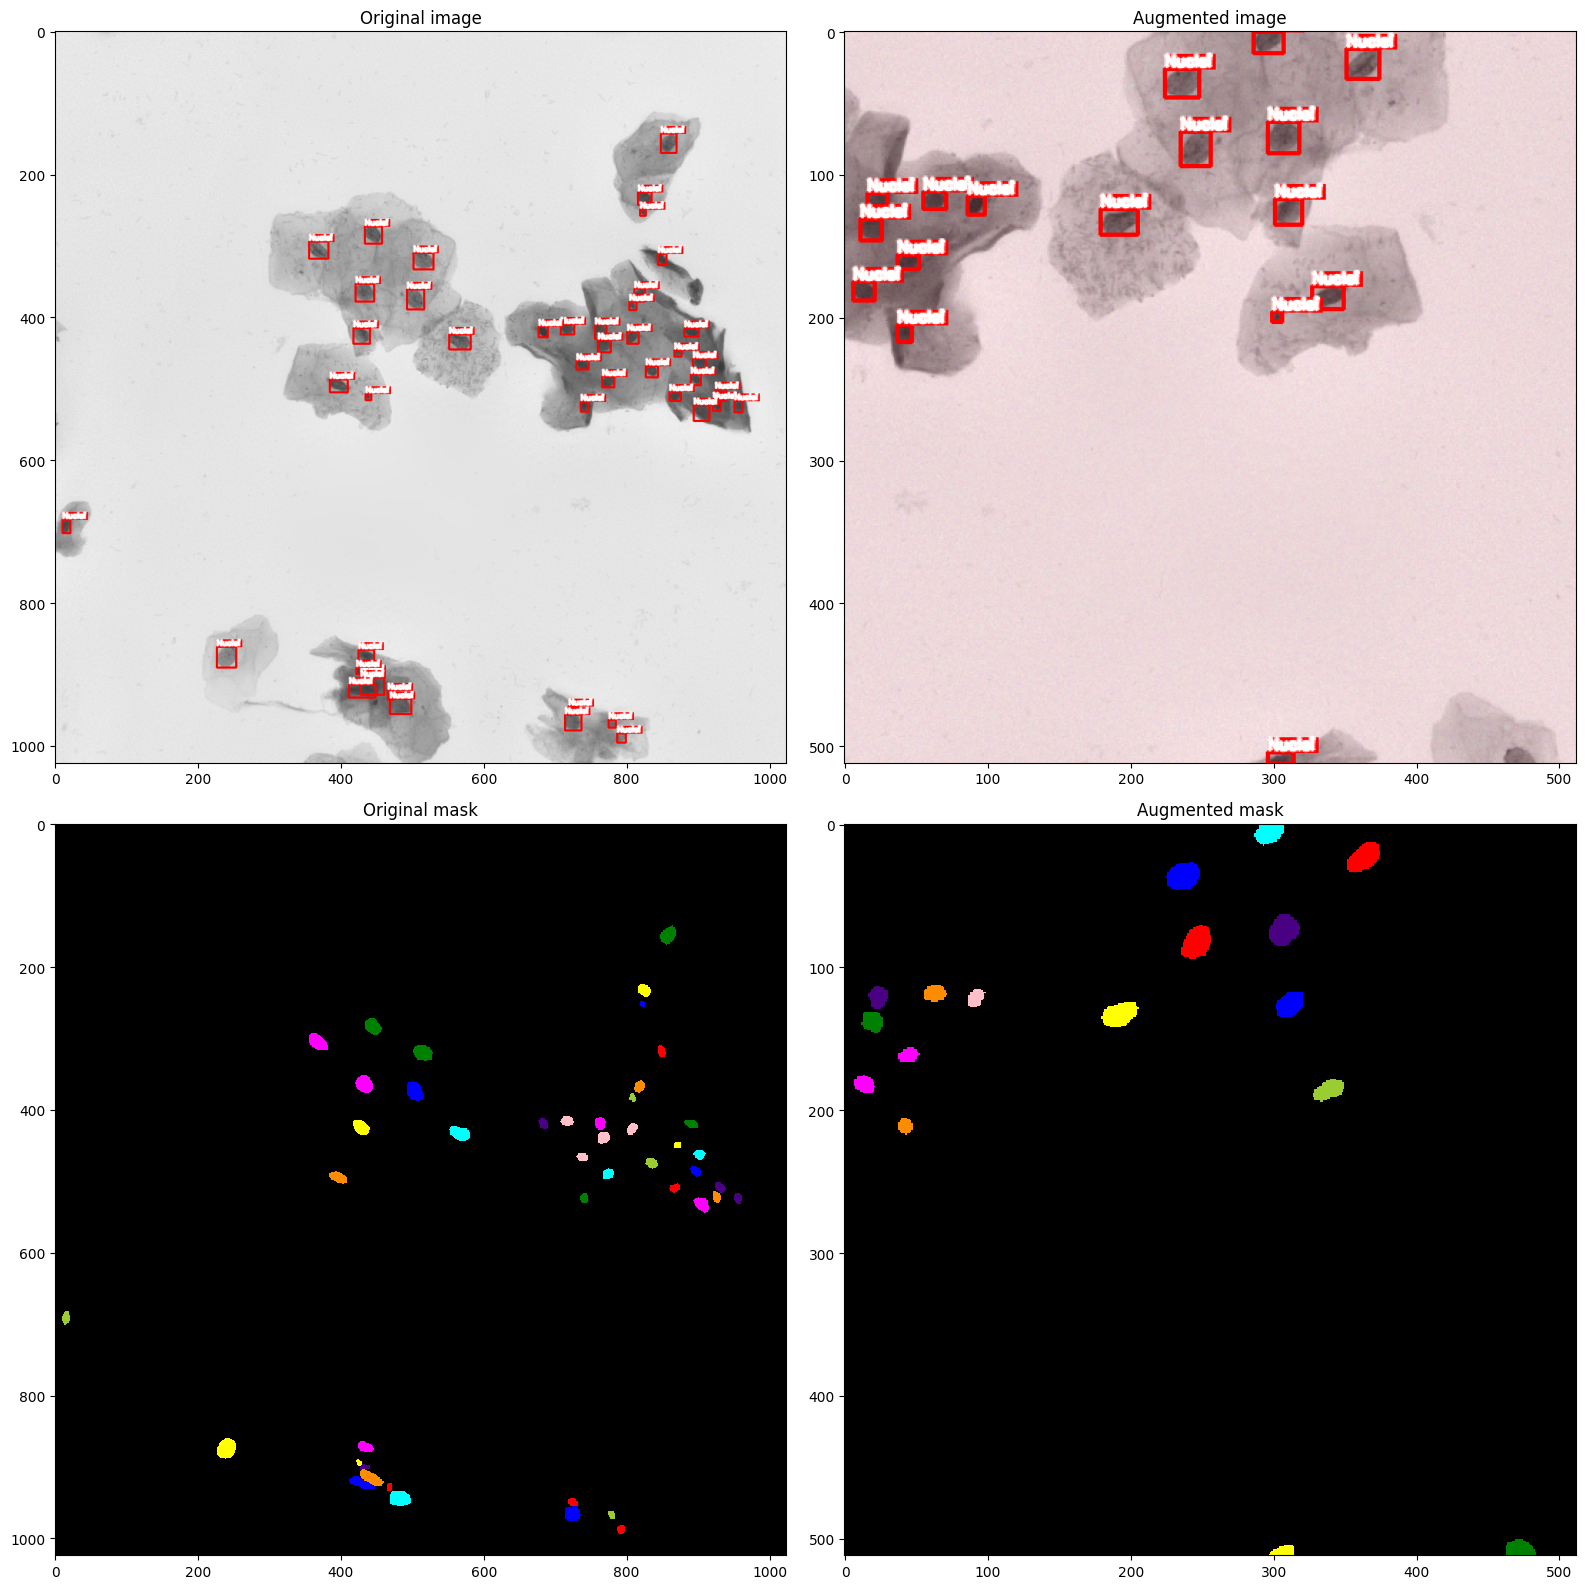

In [5]:
random.seed(42)

image = cv2.imread(
    'images/dsb2018/1a11552569160f0b1ea10bedbd628ce6c14f29edec5092034c2309c556df833e/images/1a11552569160f0b1ea10bedbd628ce6c14f29edec5092034c2309c556df833e.png')
masks = [cv2.imread(x, cv2.IMREAD_GRAYSCALE) for x in
         find_in_dir('images/dsb2018/1a11552569160f0b1ea10bedbd628ce6c14f29edec5092034c2309c556df833e/masks')]
bboxes = [cv2.boundingRect(cv2.findNonZero(mask)) for mask in masks]
label_image = np.zeros_like(masks[0])
for i, mask in enumerate(masks):
    label_image += (mask > 0).astype(np.uint8) * i

light = A.Compose([
    A.RGBShift(),
    A.InvertImg(),
    A.Blur(),
    A.GaussNoise(),
    A.Flip(),
    A.RandomRotate90(),
    A.RandomSizedCrop((512 - 100, 512 + 100), 512, 512),
], bbox_params={'format':'coco', 'min_area': 1, 'min_visibility': 0.5, 'label_fields': ['category_id']}, p=1)

label_ids = [0] * len(bboxes)
label_names = ['Nuclei']

r = augment_and_show(light, image, label_image, bboxes, label_ids, label_names)


# Mapilary Vistas

In [6]:
from PIL import Image

image = cv2.imread('images/vistas/_HnWguqEbRCphUquTMrCCA.jpg')
labels = cv2.imread('images/vistas/_HnWguqEbRCphUquTMrCCA_labels.png', cv2.IMREAD_COLOR)
instances = np.array(Image.open('images/vistas/_HnWguqEbRCphUquTMrCCA_instances.png'),dtype=np.uint16)
IGNORED = 65 * 256

instances[(instances//256 != 55) & (instances//256 != 44) & (instances//256 != 50)] = IGNORED

image = image[1000:2500, 1000:2500]
labels = labels[1000:2500, 1000:2500]
instances = instances[1000:2500, 1000:2500]

bboxes = [cv2.boundingRect(cv2.findNonZero((instances == instance_id).astype(np.uint8))) for instance_id in np.unique(instances) if instance_id != IGNORED]
instance_labels = [instance_id // 256 for instance_id in np.unique(instances) if instance_id != IGNORED]

# coco_bboxes = [list(bbox) + [label] for bbox, label in zip(bboxes, instance_labels)]
# coco_bboxes = A.convert_bboxes_to_albumentations(image.shape, coco_bboxes, source_format='coco')

titles = ["Bird",
"Ground Animal",
"Curb",
"Fence",
"Guard Rail",
"Barrier",
"Wall",
"Bike Lane",
"Crosswalk - Plain",
"Curb Cut",
"Parking",
"Pedestrian Area",
"Rail Track",
"Road",
"Service Lane",
"Sidewalk",
"Bridge",
"Building",
"Tunnel",
"Person",
"Bicyclist",
"Motorcyclist",
"Other Rider",
"Lane Marking - Crosswalk",
"Lane Marking - General",
"Mountain",
"Sand",
"Sky",
"Snow",
"Terrain",
"Vegetation",
"Water",
"Banner",
"Bench",
"Bike Rack",
"Billboard",
"Catch Basin",
"CCTV Camera",
"Fire Hydrant",
"Junction Box",
"Mailbox",
"Manhole",
"Phone Booth",
"Pothole",
"Street Light",
"Pole",
"Traffic Sign Frame",
"Utility Pole",
"Traffic Light",
"Traffic Sign (Back)",
"Traffic Sign (Front)",
"Trash Can",
"Bicycle",
"Boat",
"Bus",
"Car",
"Caravan",
"Motorcycle",
"On Rails",
"Other Vehicle",
"Trailer",
"Truck",
"Wheeled Slow",
"Car Mount",
"Ego Vehicle",
"Unlabeled"]
bbox_params = A.BboxParams(format='coco', min_area=1, min_visibility=0.5, label_fields=['category_id'])

light = A.Compose([
    A.HorizontalFlip(p=1),
    A.RandomSizedCrop((800 - 100, 800 + 100), 600, 600),
    A.GaussNoise(var_limit=(100, 150), p=1),
], bbox_params=bbox_params,  p=1)

medium = A.Compose([
    A.HorizontalFlip(p=1),
    A.RandomSizedCrop((800 - 100, 800 + 100), 600, 600),
    A.MotionBlur(blur_limit=17, p=1),
], bbox_params=bbox_params, p=1)


strong = A.Compose([
    A.HorizontalFlip(p=1),
    A.RandomSizedCrop((800 - 100, 800 + 100), 600, 600),
    A.RGBShift(p=1),
    A.Blur(blur_limit=11, p=1),
    A.RandomBrightness(p=1),
    A.CLAHE(p=1),
], bbox_params=bbox_params, p=1)

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


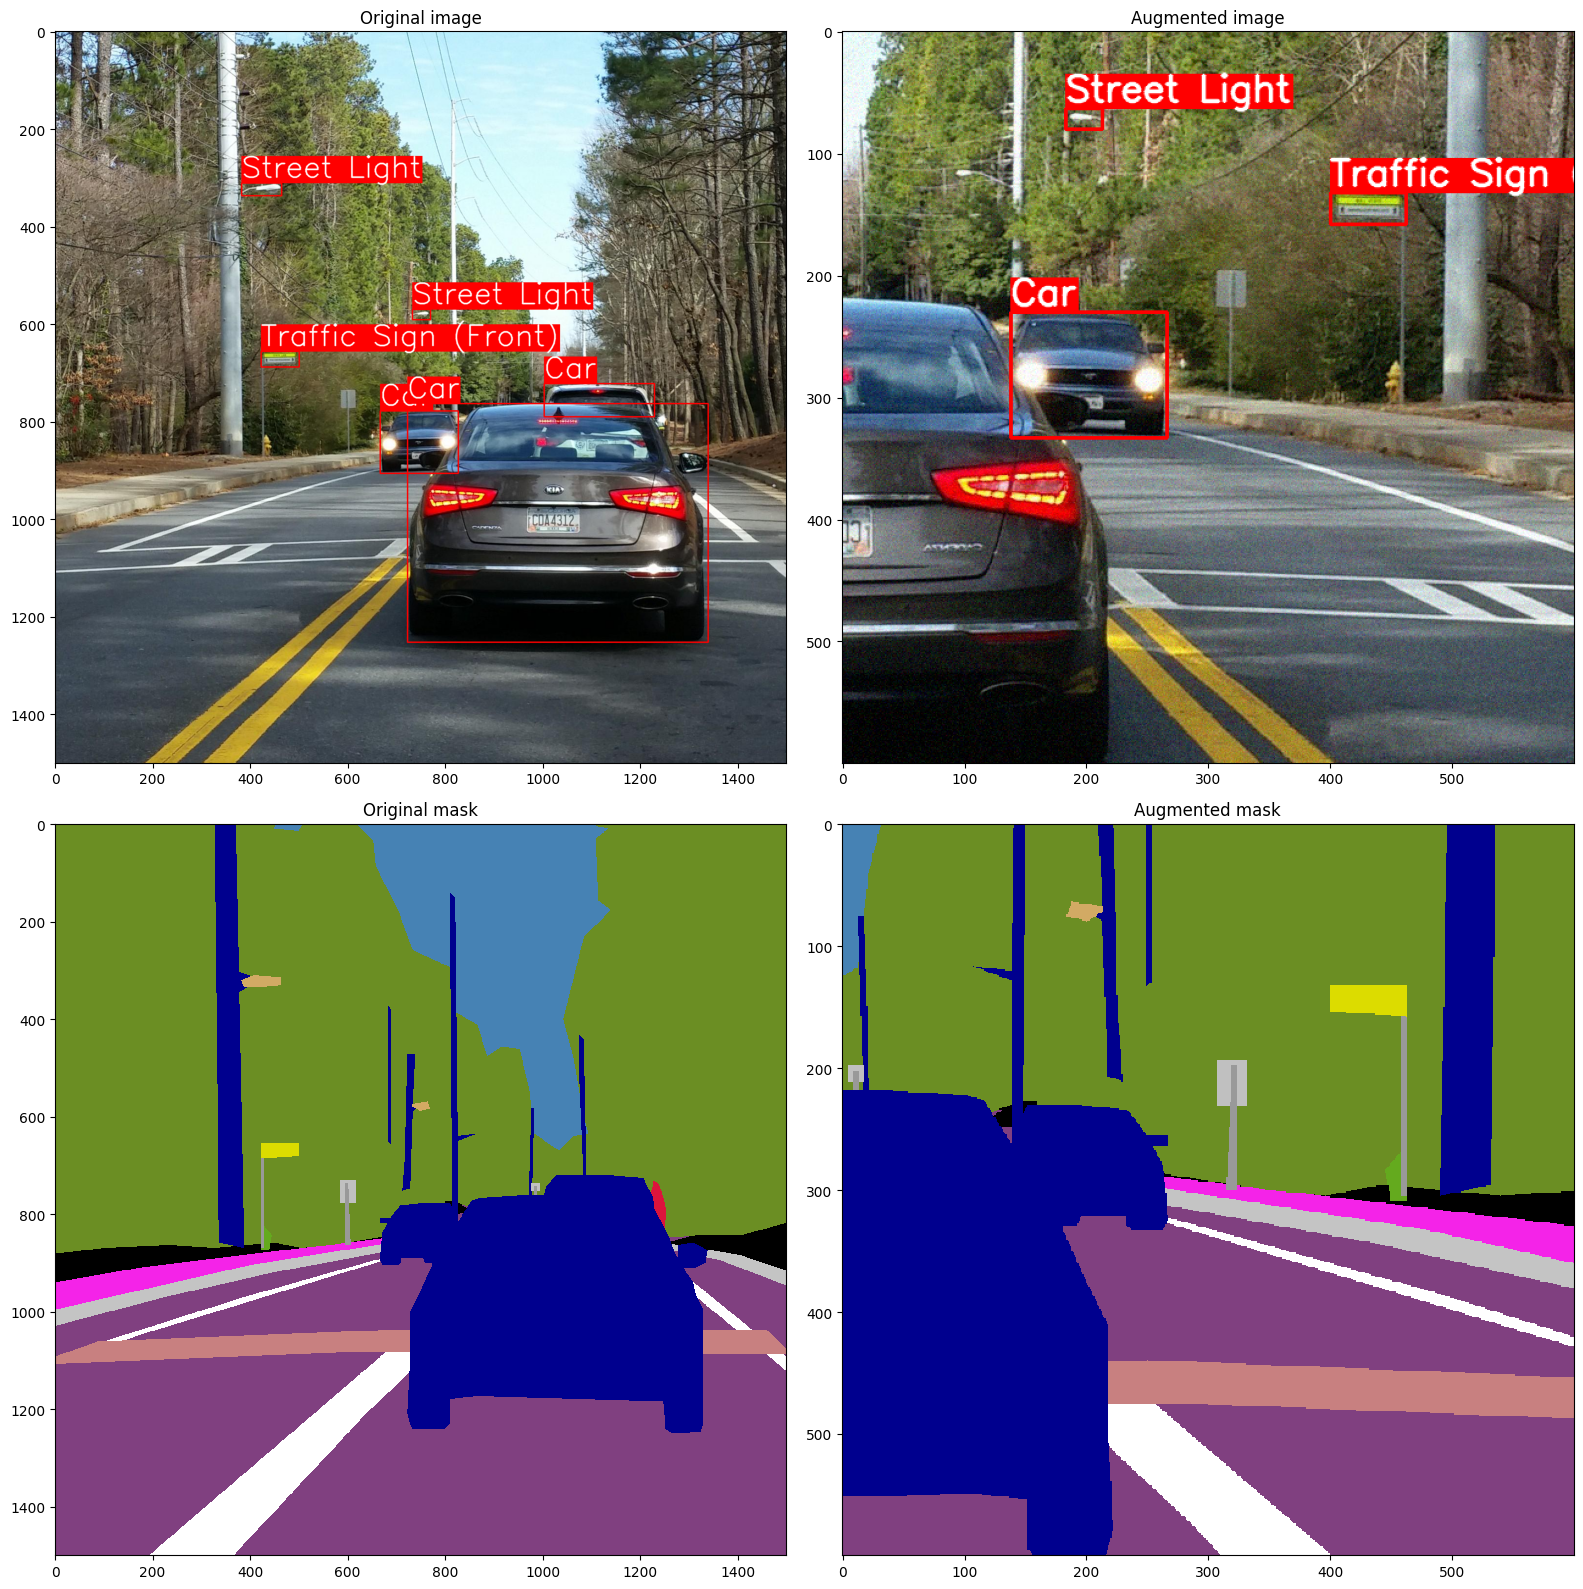

In [7]:
random.seed(13)
r = augment_and_show(light, image, labels, bboxes, instance_labels, titles, thickness=2,
                     font_scale_orig=2,
                     font_scale_aug=1)

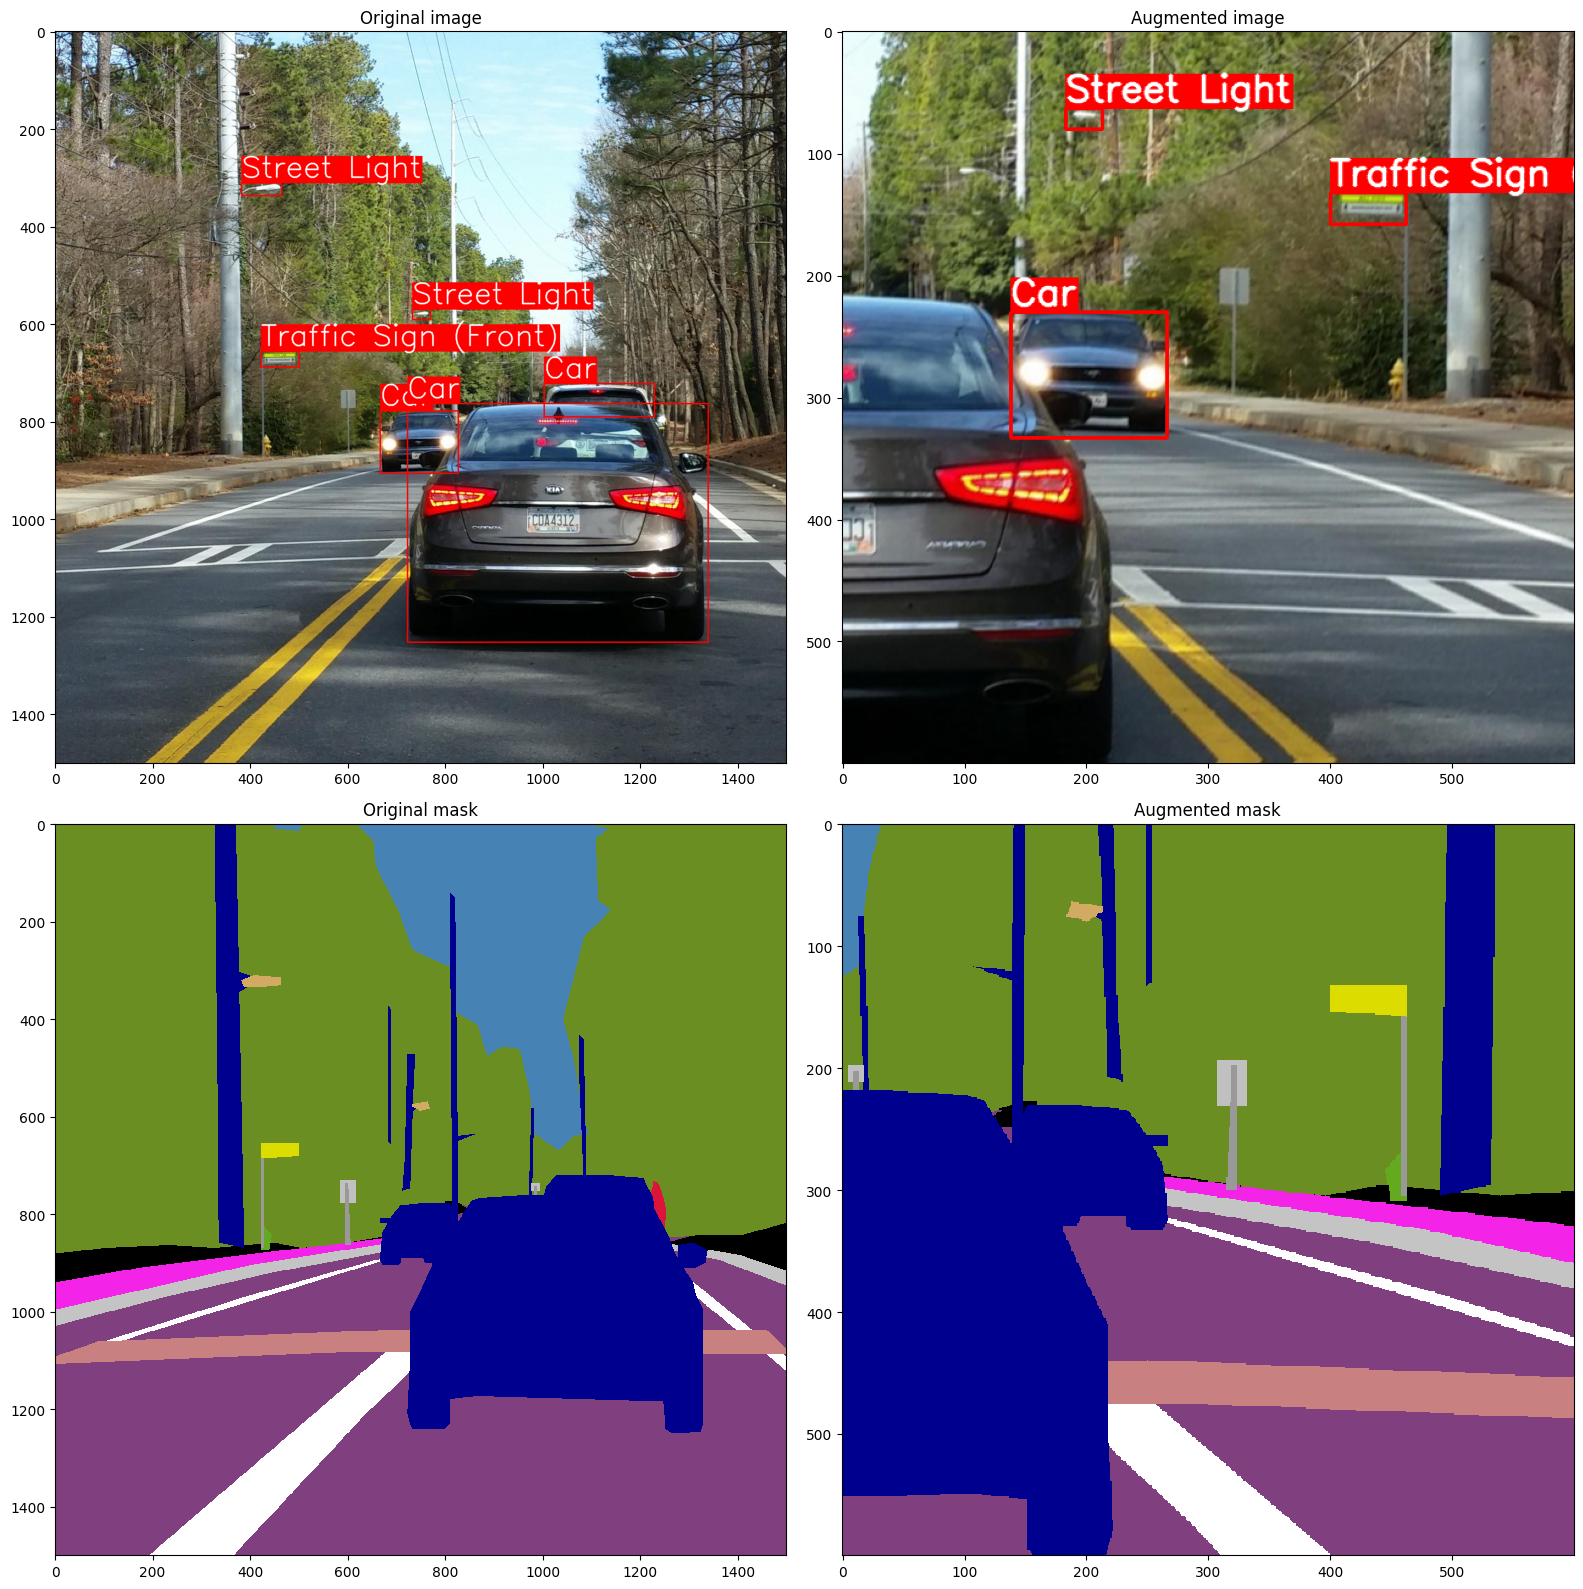

In [8]:
random.seed(13)
r = augment_and_show(medium, image, labels, bboxes, instance_labels, titles, thickness=2, font_scale_orig=2, font_scale_aug=1)

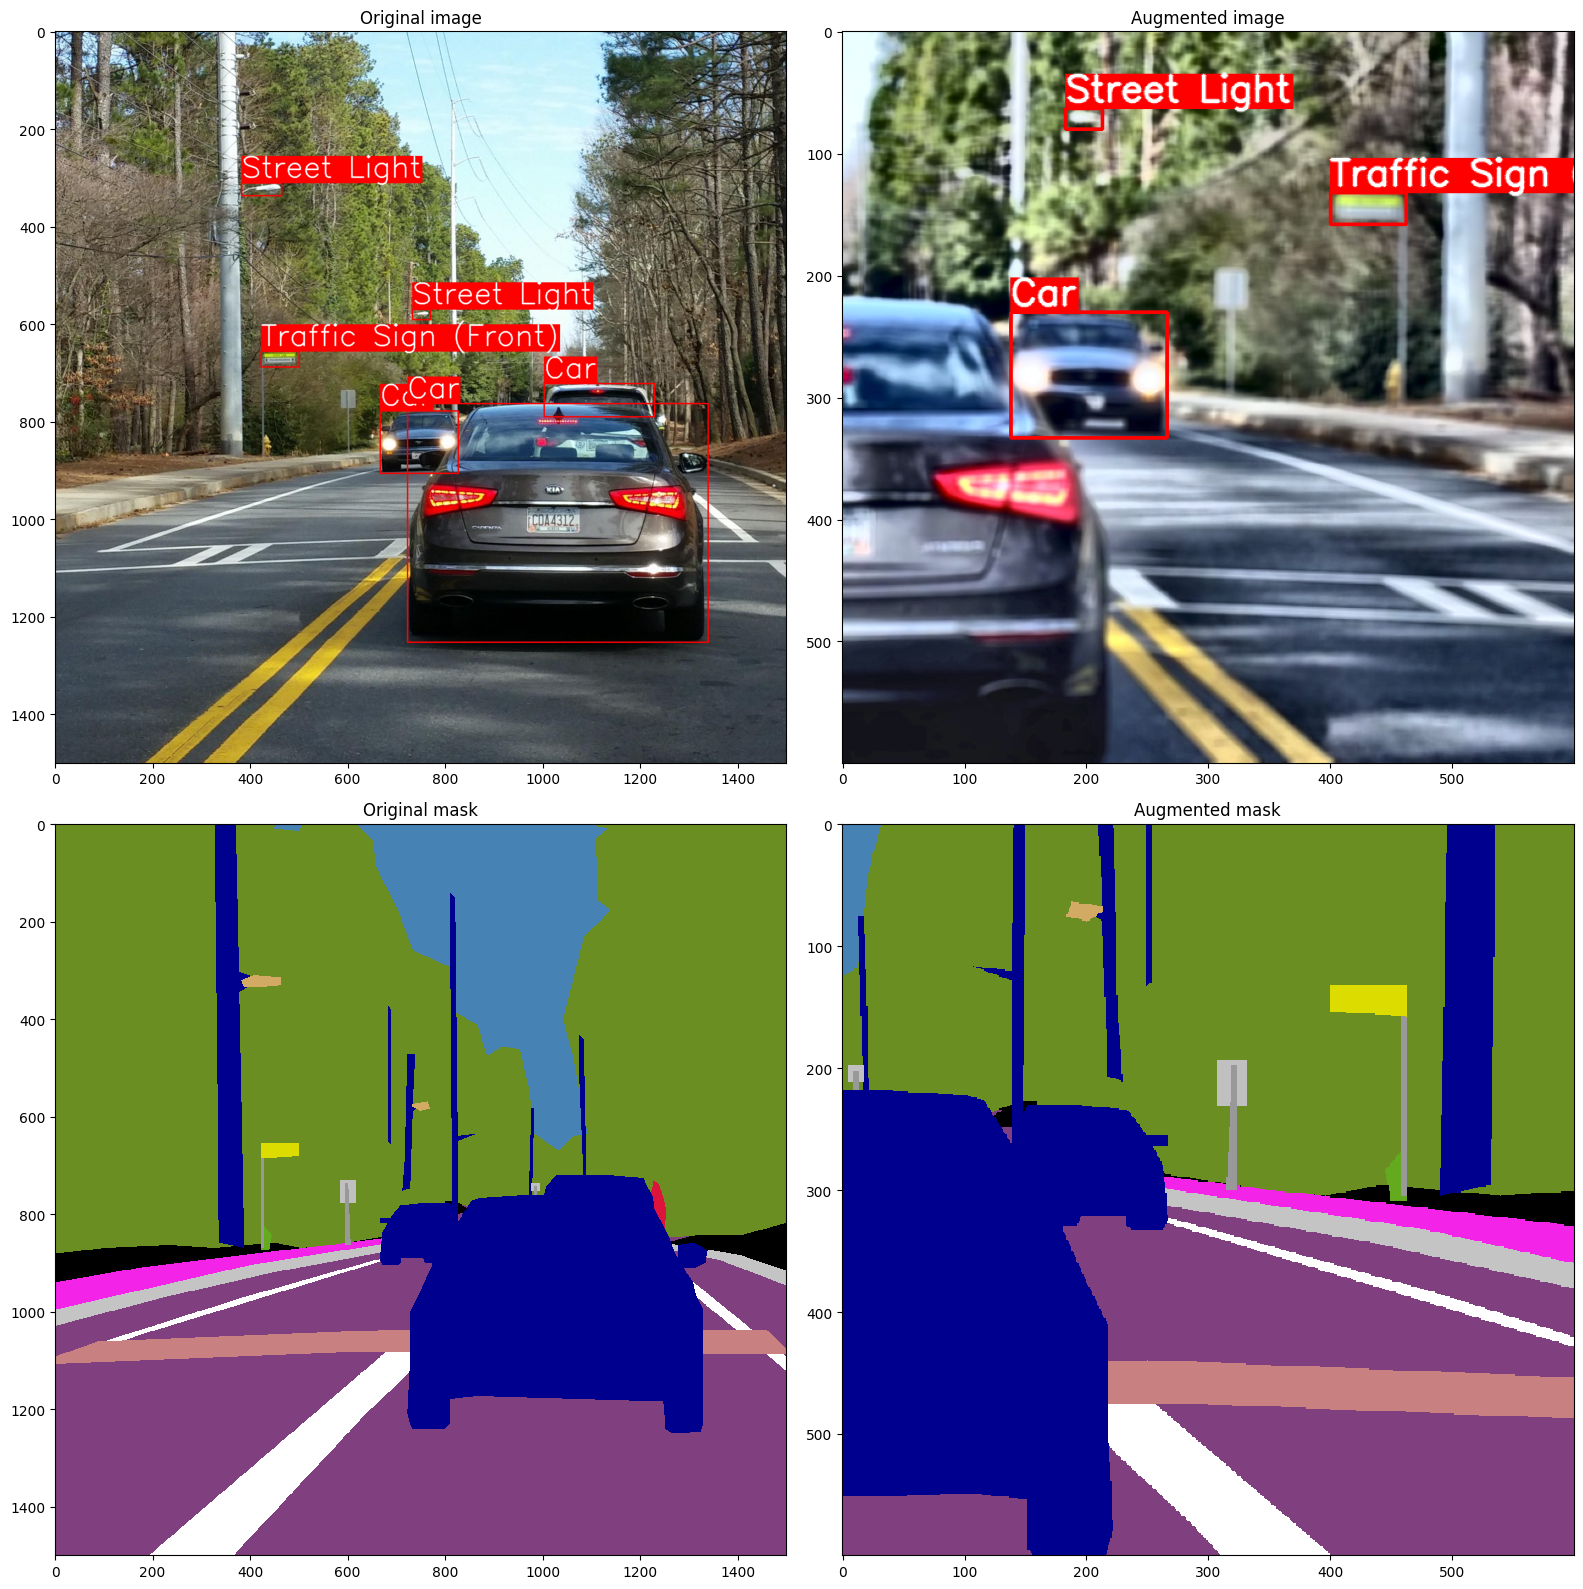

In [9]:
random.seed(13)
r = augment_and_show(strong, image, labels, bboxes, instance_labels, titles, thickness=2, font_scale_orig=2, font_scale_aug=1)